# P3 Data Wranging: OSM Data with MongoDB



The area downloaded is for the Washington Cascades.  
Coordinates area: (46,-122) x (47.2, -121)

OSM query: `(node(46.000000,-122.000000,47.200000,-121.000000);<;);out meta;`

[OSM Map link](http://www.openstreetmap.org/export#map=8/46.355/-120.396)
!['Download area for Cascades in Washington State'](download_area.png)

## Problems encountered in the map

When reveiwing the initial data retrieved, there were a few inconsistencies encountered relating to some of the natural features encoded in the data.

### Elevation of mountain peaks

Within the data, there is a tag, "ele" that is reserved for encoding elevation.  According to the [OSM wiki](http://wiki.openstreetmap.org/wiki/Key:ele), the value is supposed to be the elevation above sea level in meters.  It was primarily intended for encoding mountain peaks (natural=peak).  However, during an audit of this data, several values included a unit string in the value of "m" and others of "ft".  Still others had no elevation listed.

#### Cleaning elevations with units

To clean up the elevation values, an initial attempt at parsing the value as an int can be performed.  If this fails, a regular expression can be used to seperate the numeric and unit portions of the string.  If the unit is "m" then just the numeric poriton will be returned.  If the unit is "ft" the numeric portion will be converted to meters and returned.

In [1]:
import re
ele_re = re.compile('((?:\d*\.)?\d+)(.*)')

def clean_elevation(node):
    if 'ele' in node:
        ele_str = node['ele']
        elevation = None
        try:
            elevation = float(ele_str)
        except:
            m = ele_re.match(ele_str)
            elevation = float(m.group(1))
            unit = m.group(2).strip().lower()

            if unit == 'm':
                pass
            elif unit == 'ft':
                elevation *= .3048

        if elevation is not None:
            node['ele'] = int(round(elevation, 0))
    
    
node = dict()
node['ele'] = '1236.54 ft'
clean_elevation(node)

assert node['ele'] == 377

#### Cleaning mountain peaks with no elevation

Some peaks have no elevation listed.  If the geographic coordinates are listed, a web service provided by [MapZen](https://mapzen.com/documentation/elevation/elevation-service/) can be utilized to retrieve the value.

In [2]:
import requests


def get_elevation(pos):
    elevation = None
    url = 'http://elevation.mapzen.com/height?json={"shape":[{"lat":%s, "lon": %s}]}&api_key=elevation-xzsLksZ' \
          % (pos[0], pos[1])

    r = requests.get(url)
    if r.status_code == 200:
        elevation = r.json()['height'][0]

    return elevation


def is_mountain(node):
    return 'natural' in node and \
        (node['natural'] == 'peak' or node['natural'] == 'volcano')

    
def missing_elevation(node):
    return 'ele' not in node or node['ele'] is not None


def clean_missing_elevation(node):
    if is_mountain(node) and missing_elevation(node) and 'pos' in node:
        elevation = get_elevation(node['pos'])
        if elevation:
            node['ele'] = elevation


node = dict()
node['natural'] = 'peak'
node['pos'] = [46, -121]

clean_missing_elevation(node)
assert node['ele'] is not None

### Bodies of water

Bodies of water are represented in the data as "natural=water".  These can be further classified as using "water=*" (e.g. lake, pond, etc.).  There are many named bodies of water that do not have this further classificaiton.  By parsing the name, the classificaion can be generated.

In [3]:
def is_water(node):
    return 'natural' in node and node['natural'] == 'water'

def missing_water(node):
    return 'water' not in node or node['water'] is not None

def clean_water_classification(node):
    if is_water(node) and missing_water(node) and 'name' in node:
        name = node['name'].lower()
        if 'lake' in name:
            node['water'] = 'lake'
        elif 'pond' in name:
            node['water'] = 'pond'
        elif 'hole' in name:
            node['water'] = 'hole'
            
node = dict()
node['natural'] = 'water'
node['name'] = 'Lake Louise'

clean_water_classification(node)

assert node['water'] == 'lake'

## Overview of the data

In [4]:
import os
from pymongo import MongoClient
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_context('talk')

%matplotlib inline

client = MongoClient('localhost:27017')
db = client.dand_p3

## File sizes

In [5]:
print 'Uncompressed osm file size: %.2f MB' % (os.path.getsize('data.osm') / 1024.0 / 1024.0)
print 'Processed json file size: %.2f MB' % (os.path.getsize('data.osm.json') / 1024.0 / 1024.0)
print 'MongoDB size: %.2f MB' % (db.command('dbstats')['fileSize']/ 1024.0 / 1024.0)

Uncompressed osm file size: 60.65 MB
Processed json file size: 67.36 MB
MongoDB size: 192.00 MB


## Document counts

In [6]:
print 'Count of documents: %d' % db.osm.count()

Count of documents: 326252


In [7]:
pipline = [
    {"$group": {"_id":"$type", "count":{"$sum":1}}}
]
c = db.osm.aggregate(pipline)
pd.DataFrame(list(c))


,_id,count
0,way,10156
1,node,316096


## Natural Features

### Tallest Mountains

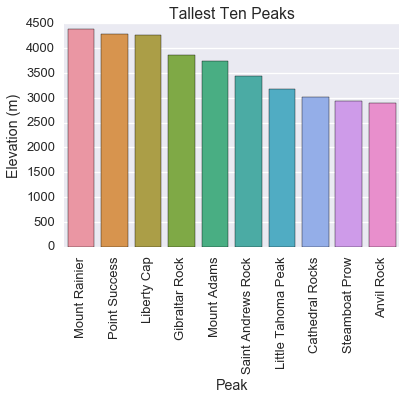

In [8]:
pipline = [
    {"$match": {"$or": [{"natural":"peak"}, {"natural":"volcano"}]}},
    {"$project": {"_id":0, "Peak":"$name", "Elevation":"$ele"}},
    {"$sort": {"Elevation": -1}},
    {"$limit": 10}
]
c = db.osm.aggregate(pipline)
df = pd.DataFrame(list(c))

ax = sns.barplot(data=df, x='Peak', y='Elevation')
ax.set_title('Tallest Ten Peaks')
ax.set_ylabel('Elevation (m)')
plt.xticks(rotation=90)
plt.show()

### Distribution of Mountain Heights

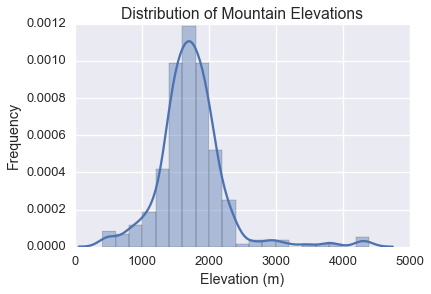

In [9]:
pipline = [
    {"$match": {"$or": [{"natural":"peak"}, {"natural":"volcano"}], "ele":{"$exists": 1}}},
    {"$project": {"_id":0, "ele": 1}}
]
c = db.osm.aggregate(pipline)
df = pd.DataFrame(list(c))


ax = sns.distplot(df['ele'], bins=20)
ax.set_title('Distribution of Mountain Elevations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Elevation (m)')
plt.show()

### Types of natural bodies of water

In [10]:
pipline = [
    {"$match": {"natural":"water"}},
    {"$group": {"_id":"$water", "count":{"$sum":1}}},
    {"$sort": {"count":-1}}
]
c = db.osm.aggregate(pipline)
pd.DataFrame(list(c))

,_id,count
0,None,498
1,lake,168
2,pond,9
3,hole,1


### Types of tourism points

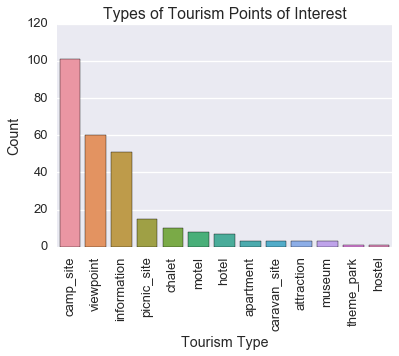

In [11]:
pipline = [
    {"$match": {"tourism":{"$exists": 1}}},
    {"$group": {"_id":"$tourism", "count":{"$sum":1}}},
    {"$sort": {"count":-1}}
]
c = db.osm.aggregate(pipline)
df = pd.DataFrame(list(c))

ax = sns.barplot(data=df, x='_id', y='count')
ax.set_title('Types of Tourism Points of Interest')
ax.set_ylabel('Count')
ax.set_xlabel('Tourism Type')
plt.xticks(rotation=90)
plt.show()

## Other ideas about the data

For "way" elements, there are only the references to the nodes which have the coordinates.  For use in mapping applications and other calculations having these coordinates directly associated with the nodes and ways would be useful.  For example, having a list of coordinates would allow for the calculation of the the distance of the path.  

For many natural features, knowing the elevation is useful.  The same technique used to fill in the missing elevations of mountains can be applied to other features.  For "way" elements, specifically hiking trails, using the starting and ending points the elevation gain/loss can be calculated.  A possible issue with how the "ways" are defined is that they are often broken up into sections.  A single hiking route that a user may be interested could be be represented as several independent ways.  OSM does have a data structure, called "relations", that fulfills this function, however it is not consistently implemented.  Some ways share common names, and may be able to programatically be joined together.  Another option would be to query for ways without relations, where the end of one way is the start of only one other. 

## References

> http://overpass-api.de/command_line.html

> https://mapzen.com/documentation/elevation/elevation-service/

> http://wiki.openstreetmap.org/wiki/Key:ele

> http://wiki.openstreetmap.org/wiki/Tag:natural%3Dwater

> http://wiki.openstreetmap.org/wiki/Relation